# Projeto

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pickle

In [2]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [3]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


## PCA:SVMS

In [4]:
def perform_PCA (DataFeatures, pca_n_features, train, data):
    ## Fit PCA to train data & rank components by AUC
    pca = PCA(n_components=len(DataFeatures))
    pca.fit(train[DataFeatures])

    ## Transform the desired dataset to get its principal components
    # Get ranked components by AUC from the train data
    principalComponents = pca.transform(train[DataFeatures])

    # Book will be a dictiorary with the AUC (values) of each component (keys)
    book = {}

    # Get values for AUC computation
    y_true = train['gen_label'].values
    weights = train["gen_xsec"].values

    # Renormalise weights
    weights[y_true == 1] = (weights[y_true == 1] / weights[y_true == 1].sum()) * weights.shape[0] / 2
    weights[y_true == 0] = (weights[y_true == 0] / weights[y_true == 0].sum()) * weights.shape[0] / 2

    for feature_idx in range(principalComponents.shape[1]):
        book[f"Component {feature_idx}"] = roc_auc_score(y_true=y_true, y_score=principalComponents[:, feature_idx], sample_weight=weights)

    # Give me the best features
    book = pd.DataFrame.from_dict(book, orient="index")
    book.columns = ["AUC"]
    book.sort_values(by="AUC", ascending=False, inplace=True)
    book.reset_index(inplace=True)
    book.rename(columns={"index": "Feature"}, inplace=True)

    ## Replace current data by its components ##
    # Get components for the current set we want
    principalComponents = pca.transform(data[DataFeatures])

    # Create a new dataframe with PCA data
    newdf = pd.DataFrame(principalComponents, columns=[f"Component {i}" for i in range(principalComponents.shape[1])])

    # Select the best components given their AUC performance in training data
    newdf = newdf[book["Feature"][0 : pca_n_features]]

    # Add the other relevant features
    newdf["gen_xsec"] = data["gen_xsec"].values
    newdf["gen_label"] = data["gen_label"].values
    newdf["gen_split"] = data["gen_split"].values

    # Finally, replace self.data with newdf
    data = newdf

    # Update DataFeatures
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
    
    return data, DataFeatures, book


In [5]:
def train_val_test(n_datapoints,n_batches,n_features,method,type):
    data_frame_fcnc_pca = data_frame_fcnc.copy()
    data_frame_bkg_pca = data_frame_bkg.copy()

    # Drop the categorical features except label, weights and gen_split
    data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
    data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

    # Drop the features that are not in both dataframes
    for feature in data_frame_fcnc_pca.columns.values:
        if feature not in data_frame_bkg_pca.columns.values:
            data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

    for feature in data_frame_bkg_pca.columns.values:
        if feature not in data_frame_fcnc_pca.columns.values:
            data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
    # Join the dataframes
    data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

    # Substitute the labels "signal" and "bkg" by 1 and 0
    data = data.replace(['signal'], 1)
    data= data.replace(['bkg'], 0)

    # train set
    train = data.loc[data['gen_split'] == 'train']
    
    # which data will be used for fitting the PCA.
    # Everything except the weights, name and label
    DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))

    
    if method == "pca":
        # perform PCA on the train data
        data, DataFeatures, book = perform_PCA (DataFeatures,n_features, train, data)
        
    elif method == "sbs":
        Features = ['MissingET_MET', 'FatJet1_Tau1','FatJet1_Tau3','Jet2_PT','Jet1_PT']
        DataFeatures = Features[:n_features]
        
    if type == "ml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()
        
    elif type == "qml":
        #normalize the data except the categorical features and the weights
        data [DataFeatures] = (((data[DataFeatures] - data[DataFeatures].min()) / (data[DataFeatures].max() - data[DataFeatures].min())) * 2 - 1) * (np.pi)
  
    # divide the new data into train, test and validation sets
    train = data.loc[data['gen_split'] == 'train']
    test = data.loc[data['gen_split'] == 'test']
    val = data.loc[data['gen_split'] == 'val']

    # divide the train data into signal and background and get n_datapoints/2*n_batches samples of each set
    train_sgn = train.loc[train['gen_label'] == 1].sample(n=int(n_datapoints/2 * n_batches),random_state=1)
    train_bkg = train.loc[train['gen_label'] == 0].sample(n=int(n_datapoints/2* n_batches),random_state=1)
    x_train_batches = [pd.concat([train_sgn[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)], train_bkg[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)]]) for i in range(n_batches)]
    for i in range(n_batches):
        x_train_batches[i] = x_train_batches[i].sample(frac=1, random_state=1)

    # divide the validation data into signal and background and get n_datapointss/2*n_batches samples of each set
    val_sgn = val.loc[val['gen_label'] == 1].sample(n=int(n_datapoints/2*n_batches), random_state=1)
    val_bkg = val.loc[val['gen_label'] == 0].sample(n=int (n_datapoints/2*n_batches), random_state=1)
    x_val_batches = [pd.concat([val_sgn[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)], val_bkg[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)]]) for i in range(n_batches)]
    for i in range(n_batches):
        x_val_batches[i] = x_val_batches[i].sample(frac=1, random_state=1)

    # divide the test data into signal and background and get n_datapoints/2*n_batches samples of each set
    test_sgn = test.loc[test['gen_label'] == 1].sample(n=int(n_datapoints/2*n_batches), random_state=1)
    test_bkg = test.loc[test['gen_label'] == 0].sample(n=int(n_datapoints/2*n_batches), random_state=1)
    x_test_batches = [pd.concat([test_sgn[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)], test_bkg[i*int(n_datapoints/2):(i+1)*int(n_datapoints/2)]]) for i in range(n_batches)]
    for i in range(n_batches):
        x_test_batches[i] = x_test_batches[i].sample(frac=1, random_state=1)

    # get an array with the labels for each set
    y_train_batches = [x_train_batches[i]['gen_label'].values for i in range(n_batches)]
    y_val_batches = [x_val_batches[i]['gen_label'].values for i in range(n_batches)]
    y_test_batches = [x_test_batches[i]['gen_label'].values for i in range(n_batches)]

    # get an array with the weights for each set
    w_train_batches = [x_train_batches[i]['gen_xsec'].values for i in range(n_batches)]
    w_val_batches = [x_val_batches[i]['gen_xsec'].values for i in range(n_batches)]
    w_test_batches = [x_test_batches[i]['gen_xsec'].values for i in range(n_batches)]

    # get an array with the features for each set
    x_train_batches = [x_train_batches[i][DataFeatures].values for i in range(n_batches)]
    x_val_batches = [x_val_batches[i][DataFeatures].values for i in range(n_batches)]
    x_test_batches = [x_test_batches[i][DataFeatures].values for i in range(n_batches)]
    
    # Renormalize weights (for each batch)
    for i in range(n_batches):
        w_train_batches[i][y_train_batches[i]==1] = w_train_batches[i][y_train_batches[i]==1] / w_train_batches[i][y_train_batches[i]==1].sum() * w_train_batches[i].shape[0] / 2
        w_train_batches[i][y_train_batches[i]==0] = w_train_batches[i][y_train_batches[i]==0] / w_train_batches[i][y_train_batches[i]==0].sum() * w_train_batches[i].shape[0] / 2
        w_test_batches[i][y_test_batches[i]==1] = w_test_batches[i][y_test_batches[i]==1] / w_test_batches[i][y_test_batches[i]==1].sum() * w_test_batches[i].shape[0] / 2
        w_test_batches[i][y_test_batches[i]==0] = w_test_batches[i][y_test_batches[i]==0] / w_test_batches[i][y_test_batches[i]==0].sum() * w_test_batches[i].shape[0] / 2
        w_val_batches[i][y_val_batches[i]==1] = w_val_batches[i][y_val_batches[i]==1] / w_val_batches[i][y_val_batches[i]==1].sum() * w_val_batches[i].shape[0] / 2
        w_val_batches[i][y_val_batches[i]==0] = w_val_batches[i][y_val_batches[i]==0] / w_val_batches[i][y_val_batches[i]==0].sum() * w_val_batches[i].shape[0] / 2
    
    return x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches

#### SVMs : Grid search to find the best hyperparameters

In [6]:
# get the train, test and validation sets
x_train_batches, y_train_batches, w_train_batches, x_val_train_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(1000,5,2,'pca','ml')

In [7]:
'''
param_grid = {
    'C': [0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001,0.001,0.01,0.1,1,10,'scale'],
    'kernel': ['linear','poly', 'rbf']
}

# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the grid search to your training data
grid_search.fit(x_train_batches[0], y_train_batches[0], sample_weight=w_train_batches[0])

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test_batches[0], y_test_batches[0], sample_weight=w_test_batches[0])
print("Test Score: ", test_score)
'''

'\nparam_grid = {\n    \'C\': [0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000],\n    \'gamma\': [0.0001,0.001,0.01,0.1,1,10,\'scale\'],\n    \'kernel\': [\'linear\',\'poly\', \'rbf\']\n}\n\n# Create an SVM classifier object\nsvm_clf = svm.SVC(probability=True)\n\n# Perform grid search with cross-validation\ngrid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring=\'roc_auc\', verbose=1, n_jobs=-1)\n\n# Fit the grid search to your training data\ngrid_search.fit(x_train_batches[0], y_train_batches[0], sample_weight=w_train_batches[0])\n\n# Print the best hyperparameters and the corresponding score on the validation set\nprint("Best Hyperparameters: ", grid_search.best_params_)\nbest_params = grid_search.best_params_\nprint("Best Score: ", grid_search.best_score_)\n\n# Evaluate the best model on the test set\nbest_model = grid_search.best_estimator_\ntest_score = best_model.score(x_test_batches[0], y_test_batches[0], sample_weight=w_test_batches[0])\nprint("Test Score: ", test_score)\n'

In [8]:
# Load data (deserialize)
with open ('dict_gridsearch_variabilidade_svm.pickle', 'rb') as handle:
    dict_gridsearch_svm = pickle.load(handle)
    
grid_search=dict_gridsearch_svm['grid_search_pca']

best_params= grid_search.best_params_

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test_batches[0], y_test_batches[0], sample_weight=w_test_batches[0])
print("Test Score: ", test_score)

Best Hyperparameters:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score:  0.7453
Test Score:  0.7409477468817618


In [9]:
def train_svm (x_train,y_train, w_train, best_params):
    clf = svm.SVC(kernel=best_params['kernel'], probability=True, C=best_params['C'], gamma=best_params['gamma'])   
    clf.fit(x_train, y_train,sample_weight=w_train)
    return clf

def val_svm (clf, x_val, y_val, w_val):
    y_pred = clf.predict(x_val)
    y_pred_prob = clf.predict_proba(x_val)[:,1]
    auc = roc_auc_score(y_val, y_pred_prob, sample_weight=w_val)
    return auc

def test_svm (clf, x_test, y_test, w_test):
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_prob, sample_weight=w_test)
    return auc

def test_svm_E (clf, x_test, y_test, w_test):
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    return y_pred_prob

In [10]:
pca_n_features_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_pca = []
auc_val_list_pca = []
auc_std_test_list_pca = []
auc_std_val_list_pca = []
ensemble_auc_test_list_pca = []
for pca_n_features in pca_n_features_list:
    for n_datapoints in n_datapoints_list:
        x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,pca_n_features,'pca','ml')
        auc_val_list = []
        auc_test_list = []
        yscores_list_E = []
        for i in range (5):
            clf = train_svm(x_train_batches[i],y_train_batches[i], w_train_batches[i], best_params)
            auc_val_list.append(val_svm(clf, x_val_batches[i], y_val_batches[i], w_val_batches[i]))
            auc_test_list.append(test_svm(clf, x_test_batches[i], y_test_batches[i], w_test_batches[i]))
            #Ensemble
            x_test = np.concatenate(x_test_batches)
            y_test = np.concatenate(y_test_batches)
            w_test= np.concatenate(w_test_batches)
            yscores_list_E.append(test_svm_E(clf, x_test, y_test, w_test))
            
        auc_val = np.mean(auc_val_list)
        auc_val_std = np.std(auc_val_list)
        auc_test = np.mean(auc_test_list)
        auc_test_std = np.std(auc_test_list)
        auc_val_list_pca.append(auc_val) 
        auc_std_val_list_pca.append(auc_val_std)
        auc_test_list_pca.append(auc_test)
        auc_std_test_list_pca.append(auc_test_std) 
        print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints))
        print('AUC Val: {}'.format(auc_val))
        print ('AUC Val std: {}'.format(auc_val_std))
        print('AUC Test: {}'.format(auc_test))
        print ('AUC Test std: {}'.format(auc_test_std))
        print('')
        # Ensemble
        yscores_E = np.mean(yscores_list_E, axis=0)
        ensemble_auc_test = roc_auc_score(y_test, yscores_E, sample_weight=w_test)
        ensemble_auc_test_list_pca.append(ensemble_auc_test)
        print ('Ensemble AUC Test: {}'.format(ensemble_auc_test))
        print('')

N_components: 1 N_datapoints: 250
AUC Val: 0.7609354462405709
AUC Val std: 0.06165878757819534
AUC Test: 0.774834194097529
AUC Test std: 0.038638279018702974

Ensemble AUC Test: 0.7804131449848462

N_components: 1 N_datapoints: 500
AUC Val: 0.795796169608135
AUC Val std: 0.05777193994816032
AUC Test: 0.7815052056387575
AUC Test std: 0.03383930390807546

Ensemble AUC Test: 0.7818854470902622

N_components: 1 N_datapoints: 1000
AUC Val: 0.797273667105566
AUC Val std: 0.038486151851493504
AUC Test: 0.780484556836554
AUC Test std: 0.02311945239312964

Ensemble AUC Test: 0.7799465826429066

N_components: 1 N_datapoints: 2000
AUC Val: 0.7921984106916932
AUC Val std: 0.02099775063637942
AUC Test: 0.7781749012178768
AUC Test std: 0.013974493438949813

Ensemble AUC Test: 0.7758374420756494

N_components: 1 N_datapoints: 4000
AUC Val: 0.7882696801547704
AUC Val std: 0.0198061140633515
AUC Test: 0.7834162910515678
AUC Test std: 0.01028618104696981

Ensemble AUC Test: 0.7831289188306493

N_compone

### Without PCA:SVM - Grid search to find the best hyperparameters

In [11]:
# get the train, test and validation sets
x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(1000,5,2,'sbs','ml')

In [12]:
'''
param_grid = {
    'C': [0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001,0.001,0.01,0.1,1,10,'scale'],
    'kernel': ['linear','poly', 'rbf']
}

# Create an SVM classifier object
svm_clf = svm.SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the grid search to your training data
grid_search.fit(x_train_batches[0], y_train_batches[0], sample_weight=w_train_batches[0])

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test_batches[0], y_test_batches[0], sample_weight=w_test_batches[0])
print("Test Score: ", test_score)
'''

'\nparam_grid = {\n    \'C\': [0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000],\n    \'gamma\': [0.0001,0.001,0.01,0.1,1,10,\'scale\'],\n    \'kernel\': [\'linear\',\'poly\', \'rbf\']\n}\n\n# Create an SVM classifier object\nsvm_clf = svm.SVC(probability=True)\n\n# Perform grid search with cross-validation\ngrid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring=\'roc_auc\', verbose=1, n_jobs=-1)\n\n# Fit the grid search to your training data\ngrid_search.fit(x_train_batches[0], y_train_batches[0], sample_weight=w_train_batches[0])\n\n# Print the best hyperparameters and the corresponding score on the validation set\nprint("Best Hyperparameters: ", grid_search.best_params_)\nbest_params = grid_search.best_params_\nprint("Best Score: ", grid_search.best_score_)\n\n# Evaluate the best model on the test set\nbest_model = grid_search.best_estimator_\ntest_score = best_model.score(x_test_batches[0], y_test_batches[0], sample_weight=w_test_batches[0])\nprint("Test Score: ", test_score)\n'

In [13]:
grid_search=dict_gridsearch_svm['grid_search_no_pca']

best_params= grid_search.best_params_

# Print the best hyperparameters and the corresponding score on the validation set
print("Best Hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
print("Best Score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test_batches[0], y_test_batches[0], sample_weight=w_test_batches[0])
print("Test Score: ", test_score)



Best Hyperparameters:  {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Score:  0.7803000000000001
Test Score:  0.6490903072629908


In [14]:
n_features_list = [1,2,3,4,5]
n_datapoints_list = [250,500,1000,2000,4000]
auc_test_list_no_pca = []
auc_val_list_no_pca = []
auc_std_test_list_no_pca = []
auc_std_val_list_no_pca = []
ensemble_auc_test_list_no_pca = []
for n_features in n_features_list:
    for n_datapoints in n_datapoints_list:
        x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,n_features,'sbs','ml')
        y_pred_prob_val_list = []
        y_pred_prob_test_list= []
        auc_val_list = []
        auc_test_list = []
        yscores_list_E = []
        for i in range (5):
            clf = train_svm(x_train_batches[i],y_train_batches[i], w_train_batches[i], best_params)
            auc_val_list.append(val_svm(clf, x_val_batches[i], y_val_batches[i], w_val_batches[i]))
            auc_test_list.append(test_svm(clf, x_test_batches[i], y_test_batches[i], w_test_batches[i]))
            #Ensemble
            x_test = np.concatenate(x_test_batches)
            y_test = np.concatenate(y_test_batches)
            w_test= np.concatenate(w_test_batches)
            yscores_list_E.append(test_svm_E(clf, x_test, y_test, w_test))
        auc_val = np.mean(auc_val_list)
        auc_val_std = np.std(auc_val_list)
        auc_test = np.mean(auc_test_list)
        auc_test_std = np.std(auc_test_list)
        auc_val_list_no_pca.append(auc_val) 
        auc_std_val_list_no_pca.append(auc_val_std)
        auc_test_list_no_pca.append(auc_test)
        auc_std_test_list_no_pca.append(auc_test_std) 
        print('N_components: {}'.format(n_features), 'N_datapoints: {}'.format(n_datapoints))
        print('AUC Val: {}'.format(auc_val))
        print ('AUC Val std: {}'.format(auc_val_std))
        print('AUC Test: {}'.format(auc_test))
        print ('AUC Test std: {}'.format(auc_test_std))
        print('')
        # Ensemble
        yscores_E = np.mean(yscores_list_E, axis=0)
        ensemble_auc_test = roc_auc_score(y_test, yscores_E, sample_weight=w_test)
        ensemble_auc_test_list_no_pca.append(ensemble_auc_test)
        print ('Ensemble AUC Test: {}'.format(ensemble_auc_test))
        print('')

N_components: 1 N_datapoints: 250
AUC Val: 0.7737183933306646
AUC Val std: 0.095559279956192
AUC Test: 0.7683667923995716
AUC Test std: 0.06097353331631656

Ensemble AUC Test: 0.7680195997913697

N_components: 1 N_datapoints: 500
AUC Val: 0.8062365025469781
AUC Val std: 0.07589005225270931
AUC Test: 0.7738261245920175
AUC Test std: 0.04468894571352042

Ensemble AUC Test: 0.7763349863805029

N_components: 1 N_datapoints: 1000
AUC Val: 0.8099346611128082
AUC Val std: 0.046392686883021735
AUC Test: 0.7982262228090878
AUC Test std: 0.03742221274930651

Ensemble AUC Test: 0.7984766224998884

N_components: 1 N_datapoints: 2000
AUC Val: 0.8184664437666707
AUC Val std: 0.022730724648779895
AUC Test: 0.7950568988495321
AUC Test std: 0.01735850310051365

Ensemble AUC Test: 0.794898408102345

N_components: 1 N_datapoints: 4000
AUC Val: 0.8175476077638557
AUC Val std: 0.007783240692352308
AUC Test: 0.8048990495573829
AUC Test std: 0.013765787457892802

Ensemble AUC Test: 0.8050893088702278

N_comp

In [15]:
'''
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.plot([1, 2, 3], [1, 2, 3], label='Test')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()
'''

"\nfig, axes = plt.subplots(2, 3, figsize=(15, 6))\n\nfor i, ax in enumerate(axes.flat):\n    if i < 5:\n        ax.plot([1, 2, 3], [1, 2, 3], label='Test')\n        ax.legend()\n    else:\n        fig.delaxes(ax)\n\nfig.tight_layout()\nplt.show()\n"

### PLOT

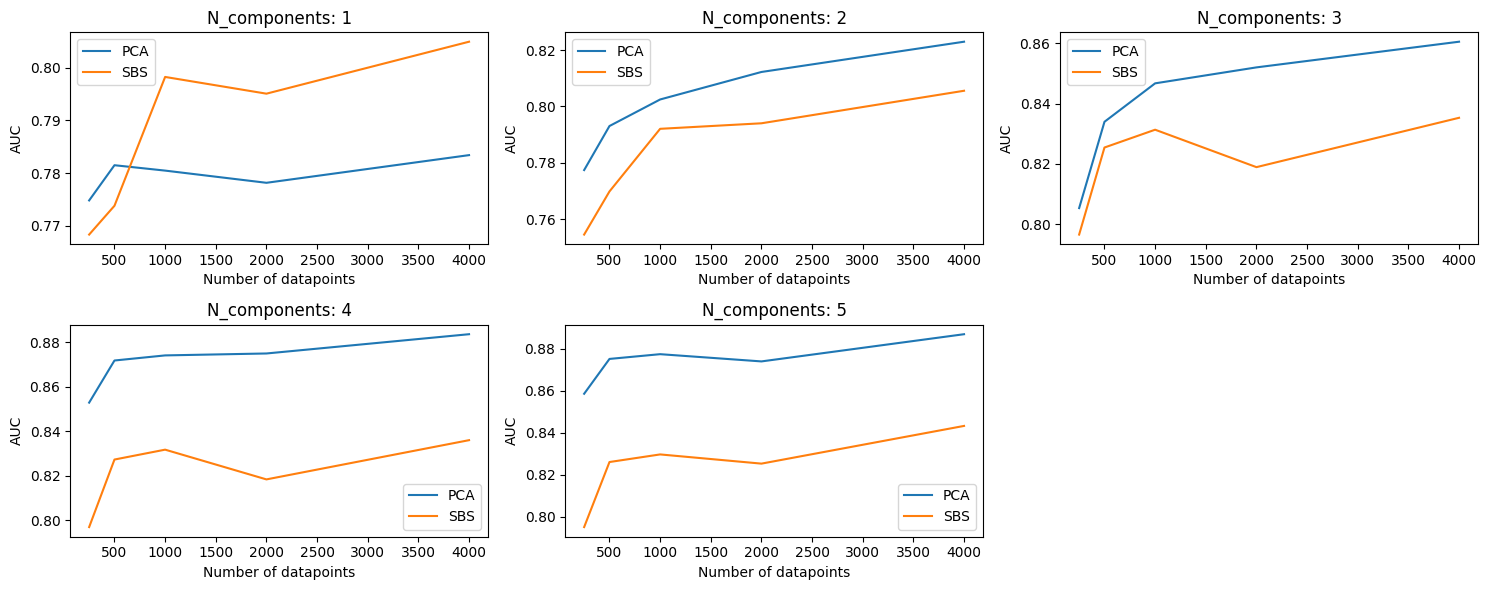

In [16]:
# Plot  the auc roc for the test set as a funtion of the number of datapoints for each number of components/features (i want to see 5 graphics seperatly with individual titles)
num_rows = 2
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i<5:
        ax.plot(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], label='PCA')
        ax.plot(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], label='SBS')
        ax.set_title('N_components: {}'.format(i+1))
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

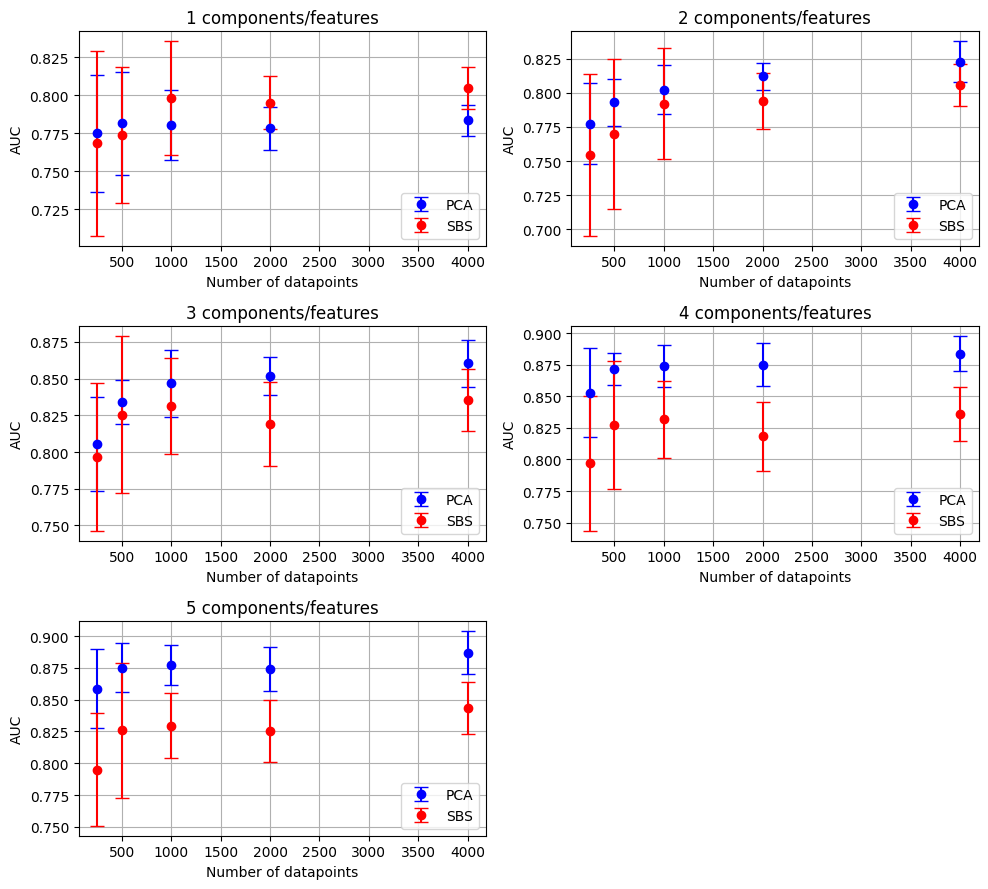

In [17]:
# Sample data for demonstration purposes
num_rows = 3
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.errorbar(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], yerr=auc_std_test_list_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='PCA', color='blue')
        ax.errorbar(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], yerr=auc_std_test_list_no_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='SBS', color='red')
        ax.set_title('{} components/features'.format(i+1))
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
        ax.grid(True)
        #ax.set_ylim(0, 1.05)
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

#### Ensemble

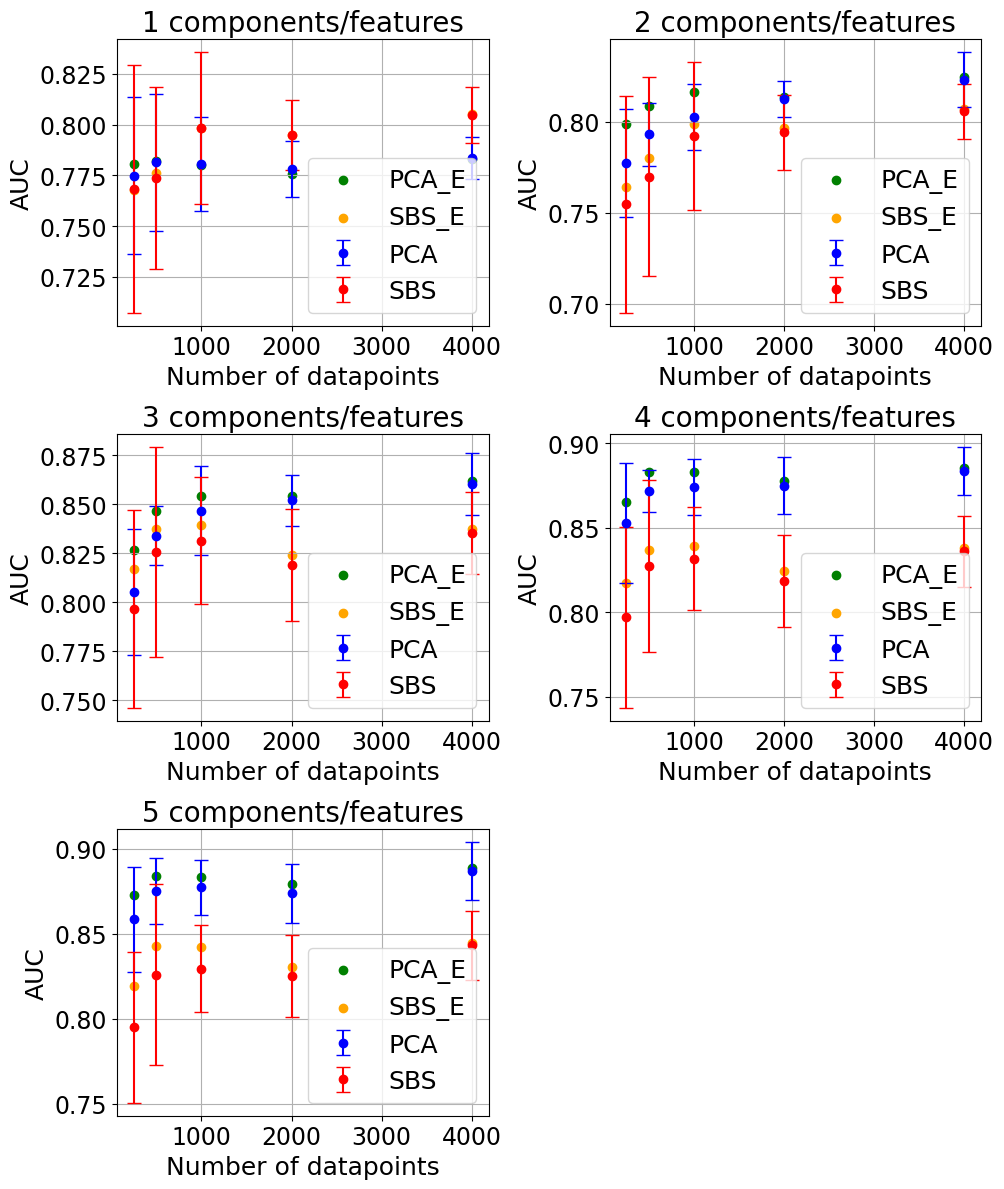

In [18]:
# Sample data for demonstration purposes
ensemble_auc_test_list_no_pca   
num_rows = 3
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    if i < 5:
        ax.errorbar(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], yerr=auc_std_test_list_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='PCA', color='blue')
        ax.errorbar(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], yerr=auc_std_test_list_no_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='SBS', color='red')
        # plot the ensemble (there are no error bars for the ensemble)
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_pca[i*5:(i+1)*5], label='PCA_E',color = 'green')
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_no_pca[i*5:(i+1)*5], label='SBS_E',color = 'orange')
        ax.set_title('{} components/features'.format(i+1),fontsize=20)
        ax.set_xlabel('Number of datapoints',fontsize=18)
        ax.set_ylabel('AUC',fontsize=18)
        ax.legend(fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=17)  # Adjust the major tick label font size
        ax.grid(True)
        #ax.set_ylim(0, 1.05)
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()

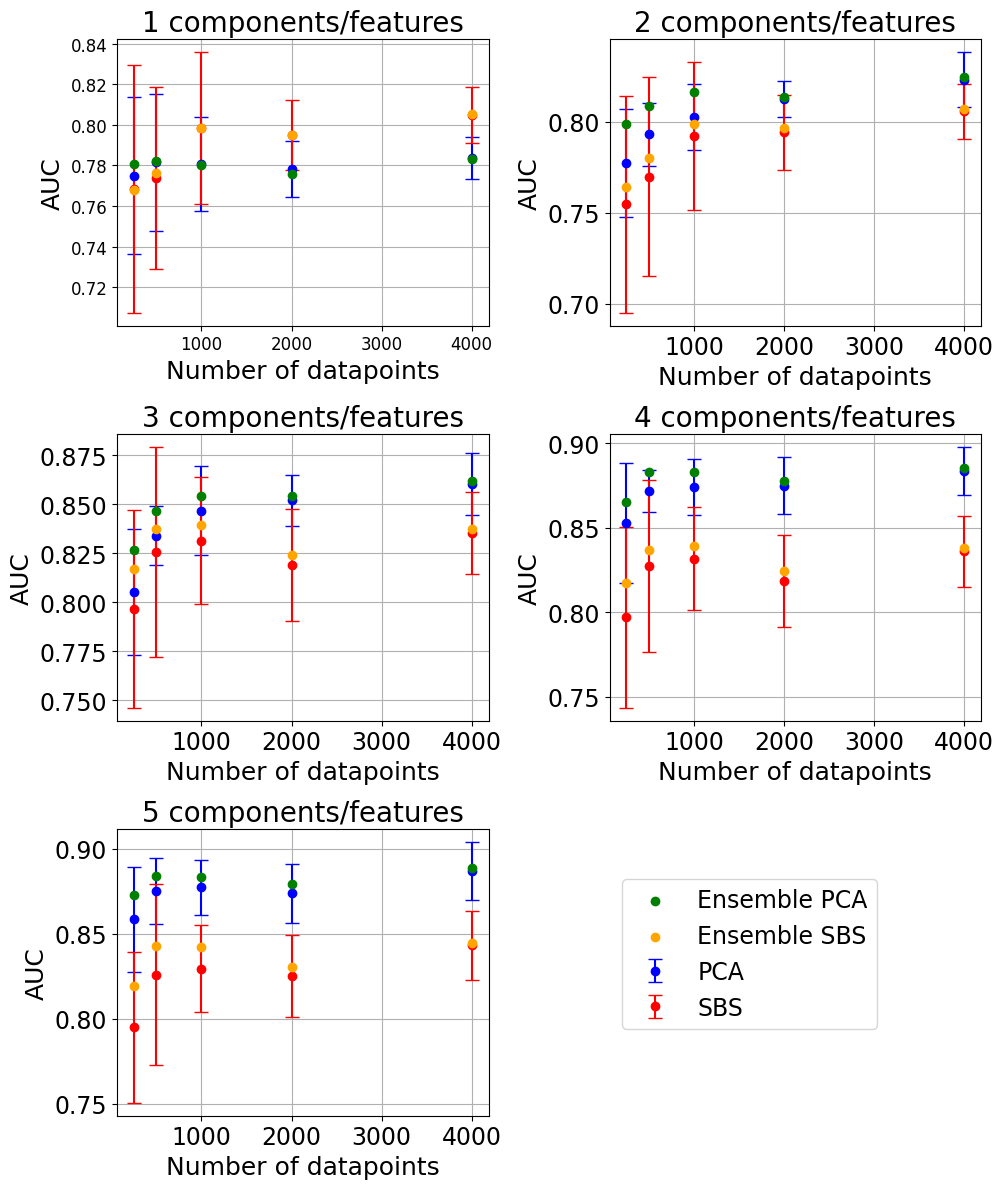

In [19]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 12))

for i, ax in enumerate(axes.flat):
    if i < 1:
        ax.errorbar(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], yerr=auc_std_test_list_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='PCA', color='blue')
        ax.errorbar(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], yerr=auc_std_test_list_no_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='SBS', color='red')
        # plot the ensemble (there are no error bars for the ensemble)
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_pca[i*5:(i+1)*5], label='Ensemble PCA', color='green', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_no_pca[i*5:(i+1)*5], label='Ensemble SBS', color='orange', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.set_title('{} components/features'.format(i+1), fontsize=20)
        ax.set_xlabel('Number of datapoints', fontsize=18)
        ax.set_ylabel('AUC', fontsize=18)
        #ax.legend(fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the major tick label font size
        ax.grid(True)
        # ax.set_ylim(0, 1.05)
    elif i < 5:
        ax.errorbar(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], yerr=auc_std_test_list_pca[i*5:(i+1)*5], fmt='o', capsize=5, color='blue')
        ax.errorbar(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], yerr=auc_std_test_list_no_pca[i*5:(i+1)*5], fmt='o', capsize=5,  color='red')
        # plot the ensemble (there are no error bars for the ensemble)
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_pca[i*5:(i+1)*5], color='green', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_no_pca[i*5:(i+1)*5], color='orange', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.set_title('{} components/features'.format(i+1), fontsize=20)
        ax.set_xlabel('Number of datapoints', fontsize=18)
        ax.set_ylabel('AUC', fontsize=18)
        #ax.legend(fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=17)  # Adjust the major tick label font size
        ax.grid(True)
        # ax.set_ylim(0, 1.05)
    else:
        ax.set_axis_off()  # Turn off the axes for the 6th subplot

# Move the legend to the black space
fig.legend(loc='center left', bbox_to_anchor=(0.6, 0.2), fontsize=17)

fig.tight_layout()
plt.show()


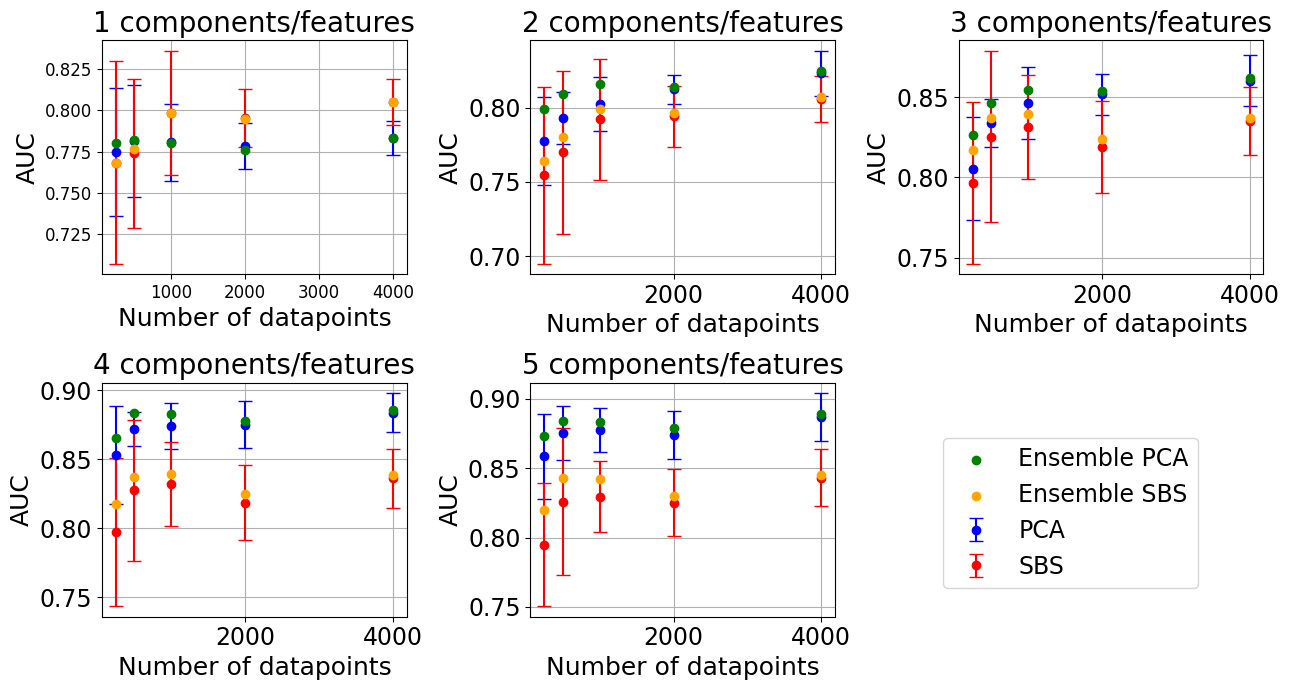

In [26]:
# Create a 3x2 grid of subplots
num_rows=2
fig, axes = plt.subplots(num_rows, 3, figsize=(13, 7))

for i, ax in enumerate(axes.flat):
    if i < 1:
        ax.errorbar(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], yerr=auc_std_test_list_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='PCA', color='blue')
        ax.errorbar(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], yerr=auc_std_test_list_no_pca[i*5:(i+1)*5], fmt='o', capsize=5, label='SBS', color='red')
        # plot the ensemble (there are no error bars for the ensemble)
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_pca[i*5:(i+1)*5], label='Ensemble PCA', color='green', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_no_pca[i*5:(i+1)*5], label='Ensemble SBS', color='orange', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.set_title('{} components/features'.format(i+1), fontsize=20)
        ax.set_xlabel('Number of datapoints', fontsize=18)
        ax.set_ylabel('AUC', fontsize=18)
        #ax.legend(fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the major tick label font size
        ax.grid(True)
        # ax.set_ylim(0, 1.05)
    elif i < 5:
        ax.errorbar(n_datapoints_list, auc_test_list_pca[i*5:(i+1)*5], yerr=auc_std_test_list_pca[i*5:(i+1)*5], fmt='o', capsize=5, color='blue')
        ax.errorbar(n_datapoints_list, auc_test_list_no_pca[i*5:(i+1)*5], yerr=auc_std_test_list_no_pca[i*5:(i+1)*5], fmt='o', capsize=5,  color='red')
        # plot the ensemble (there are no error bars for the ensemble)
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_pca[i*5:(i+1)*5], color='green', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.scatter(n_datapoints_list, ensemble_auc_test_list_no_pca[i*5:(i+1)*5], color='orange', zorder=10)  # Set zorder to 10 to ensure it's on top
        ax.set_title('{} components/features'.format(i+1), fontsize=20)
        ax.set_xlabel('Number of datapoints', fontsize=18)
        ax.set_ylabel('AUC', fontsize=18)
        #ax.legend(fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=17)  # Adjust the major tick label font size
        ax.grid(True)
        # ax.set_ylim(0, 1.05)
    else:
        ax.set_axis_off()  # Turn off the axes for the 6th subplot

# Move the legend to the black space
fig.legend(loc='center left', bbox_to_anchor=(0.72, 0.26), fontsize=17)

fig.tight_layout()
plt.show()

In [21]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

## VQC

### PCA:VQC - Grid search to find the best hyperparameters

In [ ]:
x_train_batches, y_train_batches, w_train_batches, x_val_train_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(1000,5,3,'pca','qml')

In [ ]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# quantum circuit function
def circuit(n_features, n_layers, weights, x):
        # Embedding
        
        qml.AngleEmbedding(x,range (0, n_features),rotation="X" )

        # For every layer
        for layer in range(n_layers):
            W1 = weights[layer]

            # Define Rotations
            for i in range(0,n_features):
                qml.Rot(W1[i, 0], W1[i, 1], W1[i, 2], wires=i)

            # Entanglement
            if n_features != 1:
                if n_features > 2:
                    for i in range(n_features):
                        if i == n_features - 1:
                            qml.CNOT(wires=[i, 0])
                        else:
                            qml.CNOT(wires=[i, i + 1])
                else:
                    qml.CNOT(wires=[1, 0])

        return qml.expval(qml.PauliZ(0))

# classifier function    
def classifier(n_features, n_layers, weights, x):
        #c = circuit(n_features, n_layers, weights, x)
        dev=qml.device("default.qubit", wires=n_features)
        return qml.QNode(circuit, dev)(n_features, n_layers, weights, x)
    
# cost function    
def cost(n_features, n_layers,weights,X,Y,W):  
        # Compute predictions
        y_scores = [(classifier(n_features, n_layers,weights, x) + 1) / 2 for x in X]

        loss = square_loss(Y, y_scores)
        loss = loss * W
        loss = loss.sum()
        
        return loss
    
# train step function    
def train_step(n_features, n_layers,x_train,y_train, w_train, weights, opt,desc='Training'):
        
        # Only require grad if necessary
        x_train = np.array(x_train, requires_grad=False)
        y_train = np.array(y_train, requires_grad=True)
        w_train = np.array(w_train, requires_grad=False)

        # Compute cost and update weights
        weights, loss = opt.step_and_cost(cost, n_features, n_layers,weights, X=x_train, Y=y_train, W=w_train)

        return loss, weights
    
# validation step function
def validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch,best_weights,desc='Validation'):
    X_val = np.array(x_val, requires_grad=False)
    Y_val = np.array(y_val, requires_grad=False)
    W_val = np.array(w_val, requires_grad=False)

    y_scores = np.array([classifier(n_features, n_layers, weights, x) for x in X_val])
    y_scores = (y_scores + 1) / 2

    W_val[Y_val == 1] = (W_val[Y_val == 1] / W_val[Y_val == 1].sum()) * W_val.shape[0] / 2
    W_val[Y_val == 0] = (W_val[Y_val == 0] / W_val[Y_val == 0].sum()) * W_val.shape[0] / 2

    auc_score = roc_auc_score(y_true=Y_val, y_score=y_scores, sample_weight=W_val)
    loss = cost(n_features, n_layers, weights, X_val, Y_val, W_val)


    if best_score is None or auc_score > best_score:
        best_score = auc_score
        best_score_epoch = epoch_number
        best_weights = weights

    tqdm.write(f"Epoch: {epoch_number}, Validation Loss: {loss:.4f}, AUC Score: {auc_score:.4f}")

    return best_score, best_score_epoch, best_weights
        
        
# train function
def train_vqc(n_features, n_layers, x_train, y_train,w_train,x_val,y_val,w_val, learning_rate, weights, max_epochs):
    opt = AdamOptimizer(learning_rate)
    best_score = None
    best_weights = None
    best_score_epoch = None
    epoch_number = 0

    with tqdm(total=max_epochs, desc='Epoch', unit='epoch') as pbar:
        for epoch in range(epoch_number, max_epochs):
            epoch_number = epoch

            loss, nf_nl_weights = train_step(n_features, n_layers, x_train, y_train, w_train, weights, opt, desc='Training')
            
            # Log variable values using tqdm.write
            tqdm.write(f"Epoch: {epoch_number:}, Loss: {loss:.4f}")
            
            
            weights = nf_nl_weights[2:]
            weights = weights[0]

            if epoch_number == max_epochs - 1 or (epoch_number+1)%5==0:
                best_score, best_score_epoch, best_weights = validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch, best_weights,desc='Validation')
                # early stopping
                if epoch_number - best_score_epoch > 20 and epoch_number > 60:
                    tqdm.write(f"Early stopping at epoch {epoch_number}")
                    break

            pbar.update(1)  # Update progress bar
        tqdm.write(f"Best Score: {best_score:.4f}")            
        
    return best_score, best_weights


def test_vqc(n_features, n_layers,x_test,y_test,w_test, weights):
        # Remove grad
        X_test = np.array(x_test, requires_grad=False)
        Y_test = np.array(y_test, requires_grad=False)
        W_test = np.array(w_test, requires_grad=False)

        # This will be between -1 and 1, we need to convert to between 0 and 1
        y_scores = np.array([classifier(n_features, n_layers,weights, x) for x in X_test])
        y_scores = (y_scores + 1) / 2

        # Renormalize weights
        W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
        W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2

        # Calculate ROC
        #auc_score = roc_auc_score(y_true=Y_test, y_score=y_scores, sample_weight=W_test)
        
        return y_scores

In [ ]:
x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(1000,5,2,'pca','qml')

In [ ]:
'''
n_layers = 3
n_features =2
learning_rates = [0.001, 0.005, 0.01, 0.03,0.05, 0.1, 0.5, 1.0]

# Initialize best_score and best_weights
best_score = None
best_weights = None
best_lr = None

# Iterate over each learning rate
for lr in learning_rates:
        # Random weight initialization
        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

        # Train the model
        score, weights = train_vqc(n_features, n_layers,x_train_batches[0],y_train_batches[0],w_train_batches[0], x_val_batches[0],y_val_batches[0],w_train_batches[0],lr, weights, 1000)

        # Update best_score and best_weights if necessary
        if best_score is None or score > best_score:
            best_score = score
            best_weights = weights
            best_lr = lr
'''

'\nn_layers = 3\nn_features =2\nlearning_rates = [0.001, 0.005, 0.01, 0.03,0.05, 0.1, 0.5, 1.0]\n\n# Initialize best_score and best_weights\nbest_score = None\nbest_weights = None\nbest_lr = None\n\n# Iterate over each learning rate\nfor lr in learning_rates:\n        # Random weight initialization\n        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)\n\n        # Train the model\n        score, weights = train_vqc(n_features, n_layers,x_train_batches[0],y_train_batches[0],w_train_batches[0], x_val_batches[0],y_val_batches[0],w_train_batches[0],lr, weights, 1000)\n\n        # Update best_score and best_weights if necessary\n        if best_score is None or score > best_score:\n            best_score = score\n            best_weights = weights\n            best_lr = lr\n'

In [ ]:
with open ('dict_vqc_pca_variabilidade_media_par.pickle', 'rb') as handle:
    dict_vqc = pickle.load(handle)
    
best_score=dict_vqc['best_score_pac_vqc']
best_weights =dict_vqc['best_weights_pca_vqc'] 
best_lr=dict_vqc['best_lr_pca_vqc']

print (best_score)
print (best_weights)
print (best_lr)

FileNotFoundError: [Errno 2] No such file or directory: 'dict_vqc_pca_variabilidade.pickle'

In [ ]:
'''
pca_n_features_list = [1,2]
n_layers_list = [1,2]
n_datapoints_list = [250,500]
auc_test_list_pca_vqc = []
auc_val_list_pca_vqc = []
auc_std_test_list_pca_vqc = []
auc_std_val_list_pca_vqc = []
for pca_n_features in pca_n_features_list:
    for n_layers in n_layers_list:
        for n_datapoints in n_datapoints_list:
            weights = 0.01 * np.random.randn(n_layers, pca_n_features, 3, requires_grad=True)
            x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,pca_n_features,'pca','qml')
            y_pred_prob_val_list = []
            y_pred_prob_test_list= []
            auc_val_list = []
            auc_test_list = []
            for i in range (5):             
                best_score, best_weights = train_vqc(pca_n_features, n_layers,x_train_batches[i],y_train_batches[i],w_train_batches[i], x_val_batches[i],y_val_batches[i],w_train_batches[i],best_lr, weights, 1000)
                y_pred_prob_val_list.append(test_vqc(pca_n_features, n_layers,x_val_batches[i],y_val_batches[i],w_val_batches[i], best_weights))
                y_pred_prob_test_list.append(test_vqc(pca_n_features, n_layers,x_test_batches[i],y_test_batches[i],w_test_batches[i], best_weights))
            media_y_pred_prob_test= np.mean(y_pred_prob_test_list, axis=0)
            media_y_pred_prob_val= np.mean(y_pred_prob_val_list, axis=0)
            for i in range (5):
                auc_val_list.append(roc_auc_score(y_val_batches[i],media_y_pred_prob_val, sample_weight=w_val_batches[i]))
                auc_test_list.append(roc_auc_score(y_test_batches[i],media_y_pred_prob_test, sample_weight=w_test_batches[i]))
            auc_val = np.mean(auc_val_list)
            auc_test = np.mean(auc_test_list)
            auc_val_list_pca_vqc.append(auc_val)
            auc_test_list_pca_vqc.append(auc_test)
            auc_test_std = np.std(auc_test_list)
            auc_val_std = np.std(auc_val_list)
            auc_std_test_list_pca_vqc.append(auc_test_std)
            auc_std_val_list_pca_vqc.append(auc_val_std)
            print('N_components: {}'.format(pca_n_features), 'N_datapoints: {}'.format(n_datapoints), 'N_layers: {}'.format(n_layers))
            print('AUC Val: {}'.format(auc_val))
            print ('AUC Val std: {}'.format(auc_val_std))
            print('')
            print('AUC Test: {}'.format(auc_test))
            print ('AUC Test std: {}'.format(auc_test_std))
            print('')
'''

In [ ]:
auc_test_list_pca_vqc = dict_vqc['auc_test_list_pca_vqc'] 
auc_val_list_pca_vqc = dict_vqc['auc_val_list_pca_vqc'] 
auc_std_test_list_pca_vqc=dict_vqc ['auc_std_test_list_pca_vqc']
auc_std_val_list_pca_vqc = dict_vqc['auc_std_val_list_pca_vqc'] 

### Without PCA:VQC -Grid search to find the best hyperparameters

In [ ]:
# get the train, test and validation sets
x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(1000,5,2,'sbs','qml')

In [ ]:
'''
n_layers = 3
n_features =2
learning_rates = [0.001, 0.005, 0.01, 0.03,0.05, 0.1, 0.5, 1.0]

# Initialize best_score and best_weights
best_score = None
best_weights = None
best_lr = None

# Iterate over each learning rate
for lr in learning_rates:
        # Random weight initialization
        weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

        # Train the model
        score, weights = train_vqc(n_features, n_layers,x_train_batches[0],y_train_batches[0],w_train_batches[0], x_val_batches[0],y_val_batches[0],w_train_batches[0],lr, weights, 1000)

        # Update best_score and best_weights if necessary
        if best_score is None or score > best_score:
            best_score = score
            best_weights = weights
            best_lr = lr
'''

In [ ]:
with open ('dict_vqc_no_pca_variabilidade_media_par.pickle', 'rb') as handle:
    dict_vqc = pickle.load(handle)

best_score = dict_vqc['best_score_no_pca_vqc'] 
best_weights=dict_vqc['best_weights_no_pca_vqc']
best_lr= dict_vqc['best_lr_no_pca_vqc']
print (best_score)
print (best_lr)

0.7939551347179504
1.0


In [ ]:
'''
n_features_list = [1,2]
n_layers_list = [1,2]
n_datapoints_list = [250,500]
auc_test_list_no_pca_vqc = []
auc_val_list_no_pca_vqc = []
auc_std_test_list_no_pca_vqc = []
auc_std_val_list_no_pca_vqc = []
for n_features in n_features_list:
    for n_layers in n_layers_list:
        for n_datapoints in n_datapoints_list:
            weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)
            x_train_batches, y_train_batches, w_train_batches, x_val_batches, y_val_batches, w_val_batches, x_test_batches, y_test_batches, w_test_batches = train_val_test(n_datapoints,5,n_features,'sbs','qml')
            y_pred_prob_val_list = []
            y_pred_prob_test_list= []
            auc_val_list = []
            auc_test_list = []
            for i in range (5):             
                best_score, best_weights = train_vqc(n_features, n_layers,x_train_batches[i],y_train_batches[i],w_train_batches[i], x_val_batches[i],y_val_batches[i],w_train_batches[i],best_lr, weights, 1000)
                y_pred_prob_val_list.append(test_vqc(n_features, n_layers,x_val_batches[i],y_val_batches[i],w_val_batches[i], best_weights))
                y_pred_prob_test_list.append(test_vqc(n_features, n_layers,x_test_batches[i],y_test_batches[i],w_test_batches[i], best_weights))
            media_y_pred_prob_test= np.mean(y_pred_prob_test_list, axis=0)
            media_y_pred_prob_val= np.mean(y_pred_prob_val_list, axis=0)
            for i in range (5):
                auc_val_list.append(roc_auc_score(y_val_batches[i],media_y_pred_prob_val, sample_weight=w_val_batches[i]))
                auc_test_list.append(roc_auc_score(y_test_batches[i],media_y_pred_prob_test, sample_weight=w_test_batches[i]))
            auc_val = np.mean(auc_val_list)
            auc_test = np.mean(auc_test_list)
            auc_val_list_no_pca_vqc.append(auc_val)
            auc_test_list_no_pca_vqc.append(auc_test)
            auc_test_std = np.std(auc_test_list)
            auc_val_std = np.std(auc_val_list)
            auc_std_test_list_no_pca_vqc.append(auc_test_std)
            auc_std_val_list_no_pca_vqc.append(auc_val_std)
            print('N_components: {}'.format(n_features), 'N_datapoints: {}'.format(n_datapoints), 'N_layers: {}'.format(n_layers))
            print('AUC Val: {}'.format(auc_val))
            print ('AUC Val std: {}'.format(auc_val_std))
            print('')
            print('AUC Test: {}'.format(auc_test))
            print ('AUC Test std: {}'.format(auc_test_std))
            print('')
'''

In [ ]:
uc_test_list_no_pca_vqc = dict_vqc['auc_test_list_no_pca_vqc'] 
auc_val_list_no_pca_vqc = dict_vqc['auc_val_list_no_pca_vqc'] 
auc_std_test_list_no_pca_vqc=dict_vqc ['auc_std_test_list_no_pca_vqc']
auc_std_val_list_no_pca_vqc = dict_vqc['auc_std_val_list_no_pca_vqc'] 

### PLOT

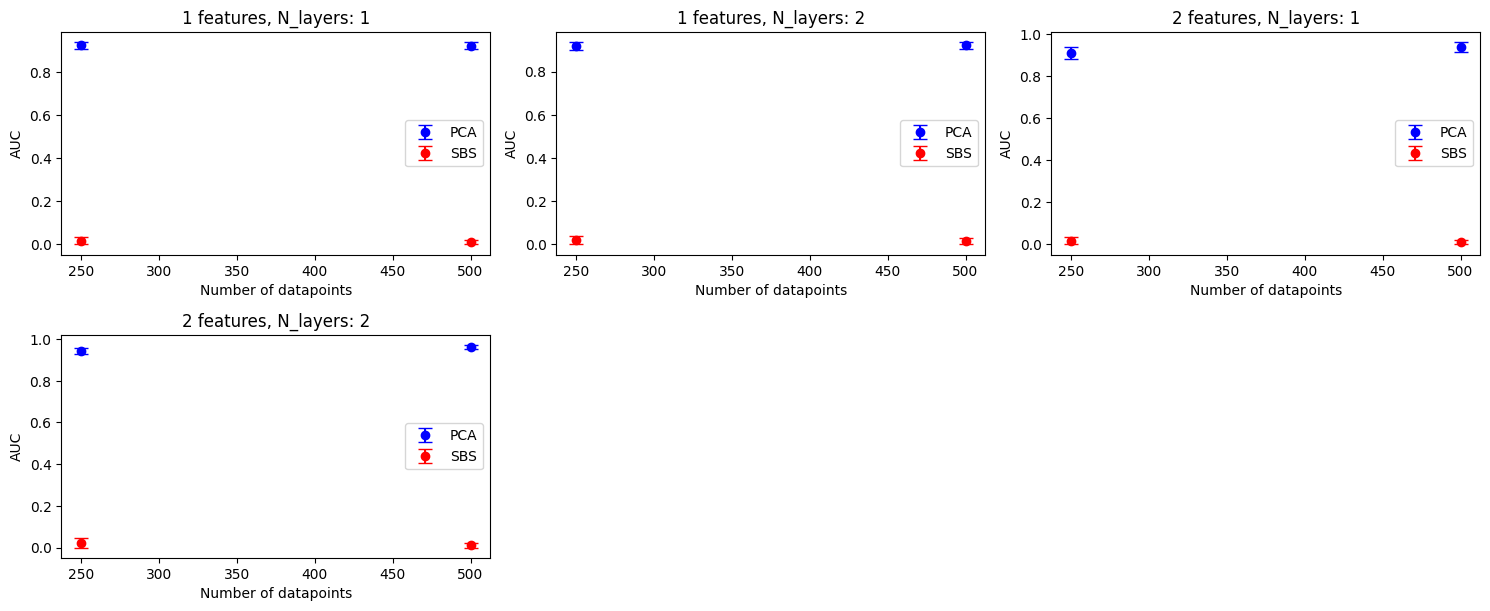

In [ ]:
n_features_list = [1,2]
n_layers_list = [1,2]
n_datapoints_list = [250,500]
num_rows = 9
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
for i, ax in enumerate(axes.flat):
    if i < 4:
        ax.errorbar(n_datapoints_list, auc_test_list_pca_vqc[i * 2:(i + 1) * 2], yerr=auc_std_test_list_pca_vqc[i*2:(i+1)*2], fmt='o', capsize=5, label='PCA', color='blue')
        ax.errorbar(n_datapoints_list, auc_std_test_list_no_pca_vqc[i * 2:(i + 1) * 2], yerr=auc_std_test_list_no_pca_vqc[i*2:(i+1)*2], fmt='o', capsize=5, label='SBS', color='red')
        ax.set_title('{} features, N_layers: {}'.format((i // 2) + 1, i % 2 + 1))
        ax.set_xlabel('Number of datapoints')
        ax.set_ylabel('AUC')
        ax.legend()
    else:
        fig.delaxes(ax)

fig.tight_layout()
plt.show()